In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
from scipy.optimize import minimize   

tickers = ['VTI', 'AGG', 'DBC', '^VIX']


In [2]:
def get_data(tickers, window=50):
    # Télécharger les données ajustées
    data = yf.download(tickers, start="2011-01-01", end="2020-04-30", interval="1d")['Adj Close']
    
    # Supprimer les lignes avec des valeurs NaN
    data_na = data.dropna(axis=0)
    
    # Ajouter les rendements quotidiens et les décaler pour obtenir 'y'
    for column in data_na.columns:
        data_na[f'{column}_R'] = data_na[f'{column}'].pct_change()  # Rendement quotidien
        data_na[f'{column}_y'] = data_na[f'{column}_R'].shift(-1)   # Rendement décalé
    
    # Réinitialiser l'index
    data_na.reset_index(inplace=True)

    # Convertir la colonne 'Date' au format date
    data_na['Date'] = data_na['Date'].dt.date
    
    # Calcul des rendements quotidiens (sur l'ensemble des tickers)
    returns = data.pct_change().dropna()

    # Moyenne des rendements mobiles sur une fenêtre donnée
    rolling_returns = returns.rolling(window=window).mean().dropna()

    # Volatilité ex-ante avec une fenêtre mobile de 50 jours
    volatility = returns.rolling(window=window).std().dropna()

    # Retourner toutes les données
    return data_na, returns, rolling_returns, volatility

In [3]:
# Appel de la fonction
data_na, returns, rolling_returns, volatility = get_data(['VTI', 'AGG', 'DBC', '^VIX'])


[*********************100%***********************]  4 of 4 completed


In [5]:
# Paramètres
volatility_target = 0.10  
cost_rate = 0.01 
risk_free_rate = 0

In [4]:
# rendements moyens et la matrice de covariance
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

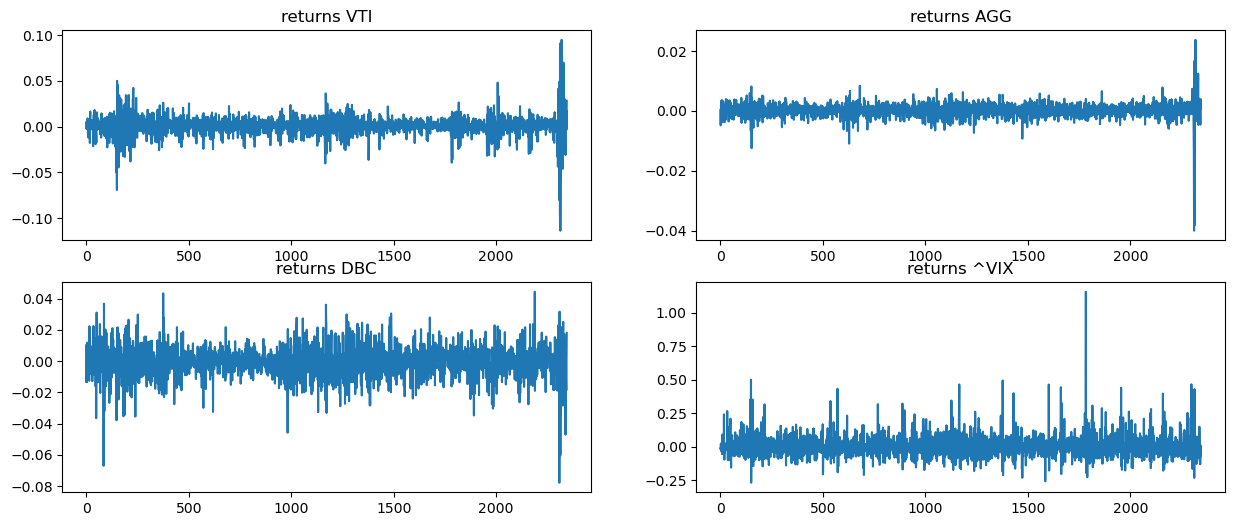

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))

axes = axes.flatten()

for i, ticker in enumerate(tickers):
    axes[i].plot(returns[ticker].values)
    axes[i].set_title(f"returns {ticker}")
plt.show()


## Mean-variance optimisation (sharpe ratio optimisation)

In [28]:
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    # Calculate the Sharpe ratio
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe  # Minimizing, so we return the negative Sharpe ratio

def optimize_portfolio(returns, risk_free_rate=0):
    num_assets = returns.shape[1]
    window = 50

    # Initial equal weights
    weights_init = np.ones(num_assets) / num_assets

    # Constraints: sum of weights equals 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds: each weight between 0 and 1 (no short selling)
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Calculate rolling means and covariances
    rolling_returns = returns.rolling(window=window).mean().dropna()
    rolling_cov_matrix = returns.rolling(window=window).cov().dropna()

    # Store daily optimized weights
    weights_matrix = np.zeros((len(rolling_returns), num_assets))

    # Loop over each day after the first `window` days
    for day in range(len(rolling_returns)):
        # Get the mean returns and covariance matrix for the current day
        mean_returns = rolling_returns.iloc[day]
        cov_matrix = rolling_cov_matrix.loc[rolling_returns.index[day]]

        # Minimize the Sharpe ratio (maximize -Sharpe)
        result = minimize(
            sharpe_ratio,
            weights_init,
            args=(mean_returns, cov_matrix, risk_free_rate),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        # Store the optimized weights
        weights_matrix[day] = result.x

    # Return the weights as a DataFrame
    return pd.DataFrame(weights_matrix, index=rolling_returns.index, columns=returns.columns)


In [29]:
weights_mv=optimize_portfolio(returns)

In [30]:
weights_mv

Ticker,AGG,DBC,VTI,^VIX
Date,,,,
2011-03-16 00:00:00+00:00,0.275565,2.006138e-02,0.629510,0.074863
2011-03-17 00:00:00+00:00,0.264481,6.805035e-02,0.598045,0.069424
2011-03-18 00:00:00+00:00,0.373617,6.214094e-02,0.507422,0.056820
2011-03-21 00:00:00+00:00,0.353161,8.048532e-02,0.512458,0.053895
2011-03-22 00:00:00+00:00,0.261513,1.142666e-01,0.562784,0.061436
...,...,...,...,...
2020-04-23 00:00:00+00:00,0.562451,5.152129e-16,0.270823,0.166726
2020-04-24 00:00:00+00:00,0.563025,4.182039e-16,0.273268,0.163707
2020-04-27 00:00:00+00:00,0.521403,0.000000e+00,0.306200,0.172397


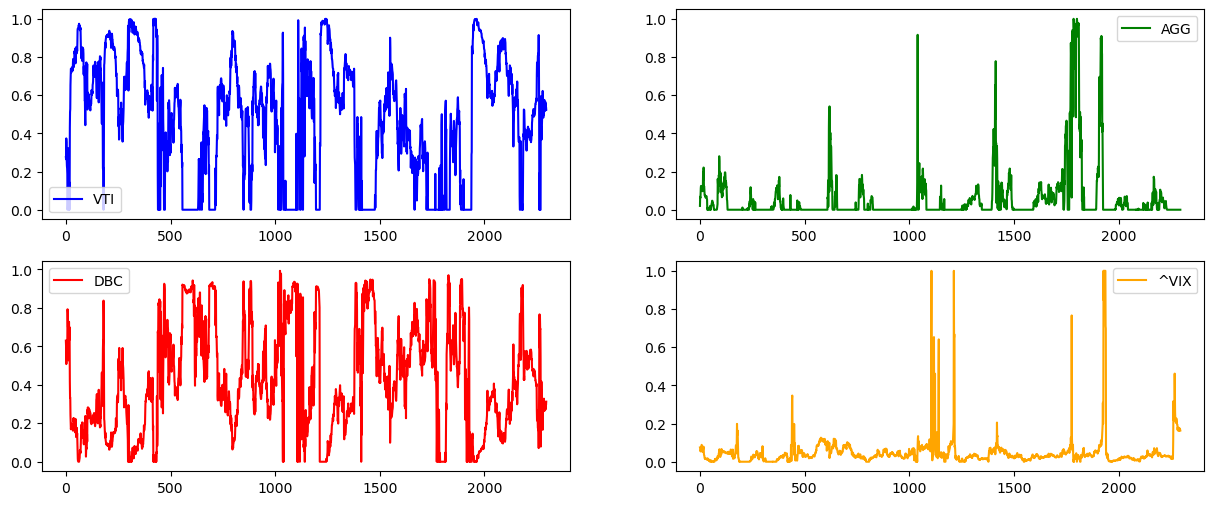

In [31]:
fig, axs = plt.subplots(2,2, figsize=(15, 6))
colors = ['blue', 'green', 'red', 'orange']
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].plot(weights_mv.iloc[:,i].values, label=tickers[i], color=colors[i])
    axs[i].legend()


In [50]:
# Sélection des données entre le 21 avril 2011 et le 29 avril 2020
selected_returns = returns.loc["2011-03-16":"2020-04-29"]


In [51]:
# Element-wise product between rolling returns and optimized weights
weighted_returns = selected_returns.values * weights_mv.values

# Sum across columns to obtain daily portfolio returns
portfolio_mv_returns = weighted_returns.sum(axis=1)
portfolio_mv_returns = pd.DataFrame(portfolio_mv_returns, columns=["portfolio_mv_returns"])

# Calculate cumulative returns
portfolio_mv_returns["cumulative_rets"] = (1 + portfolio_mv_returns["portfolio_mv_returns"]).cumprod() - 1


In [55]:
# Calcul de l'espérance des rendements (moyenne)
expected_return = portfolio_returns.mean()
expected_return = (expected_return+1)**252-1

# Calcul de la standard déviation
std_dev = portfolio_returns.std() * np.sqrt(252)
risk_free_rate = 0.0

# Calcul du Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

# Affichage des résultats
print(f"Espérance des rendements : {expected_return:.4f}")
print(f"Standard déviation : {std_dev:.4f}")
print(f"Sharpe ratio : {sharpe_ratio:.4f}")


Espérance des rendements : 0.2519
Standard déviation : 0.0230
Sharpe ratio : 10.9551


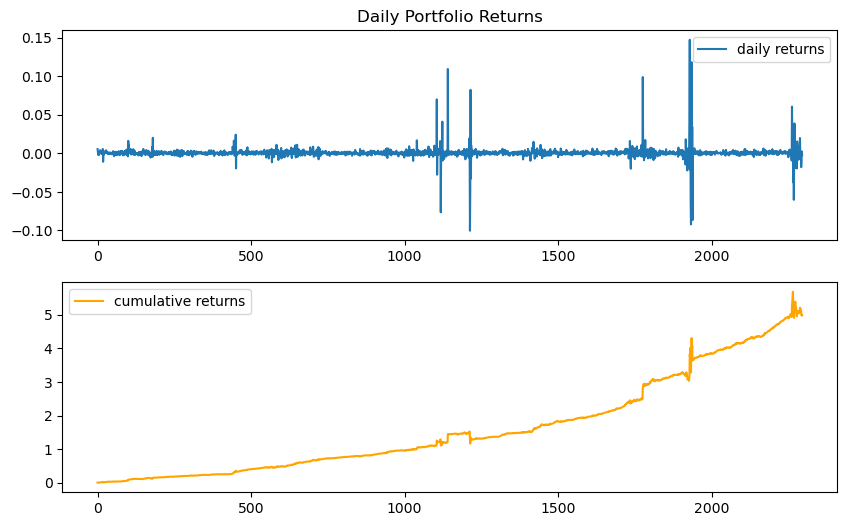

In [54]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot daily returns
axs[0].plot(portfolio_mv_returns["portfolio_mv_returns"].values, label="daily returns")
axs[0].legend()
axs[0].set_title("Daily Portfolio Returns")

# Plot cumulative returns
axs[1].plot(portfolio_mv_returns["cumulative_rets"].values, label="cumulative returns", color='orange')
axs[1].legend()
